   FID_             FULLNAME   RH     DateTime  MAX15  HR_2  HR_72  w_depth  \
0     0  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   
1     1  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   
2     2  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   
3     3  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   
4     4  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   

   TD_HR       ELV          DTW       TWI  
0   0.61  3.449655  2032.268709  7.511351  
1   0.61  3.351578  2289.101516  7.397089  
2   0.61  3.355286  2170.271564  7.548316  
3   0.61  3.489952  2261.629379  8.816202  
4   0.61  3.421316  2262.551560  9.006661  


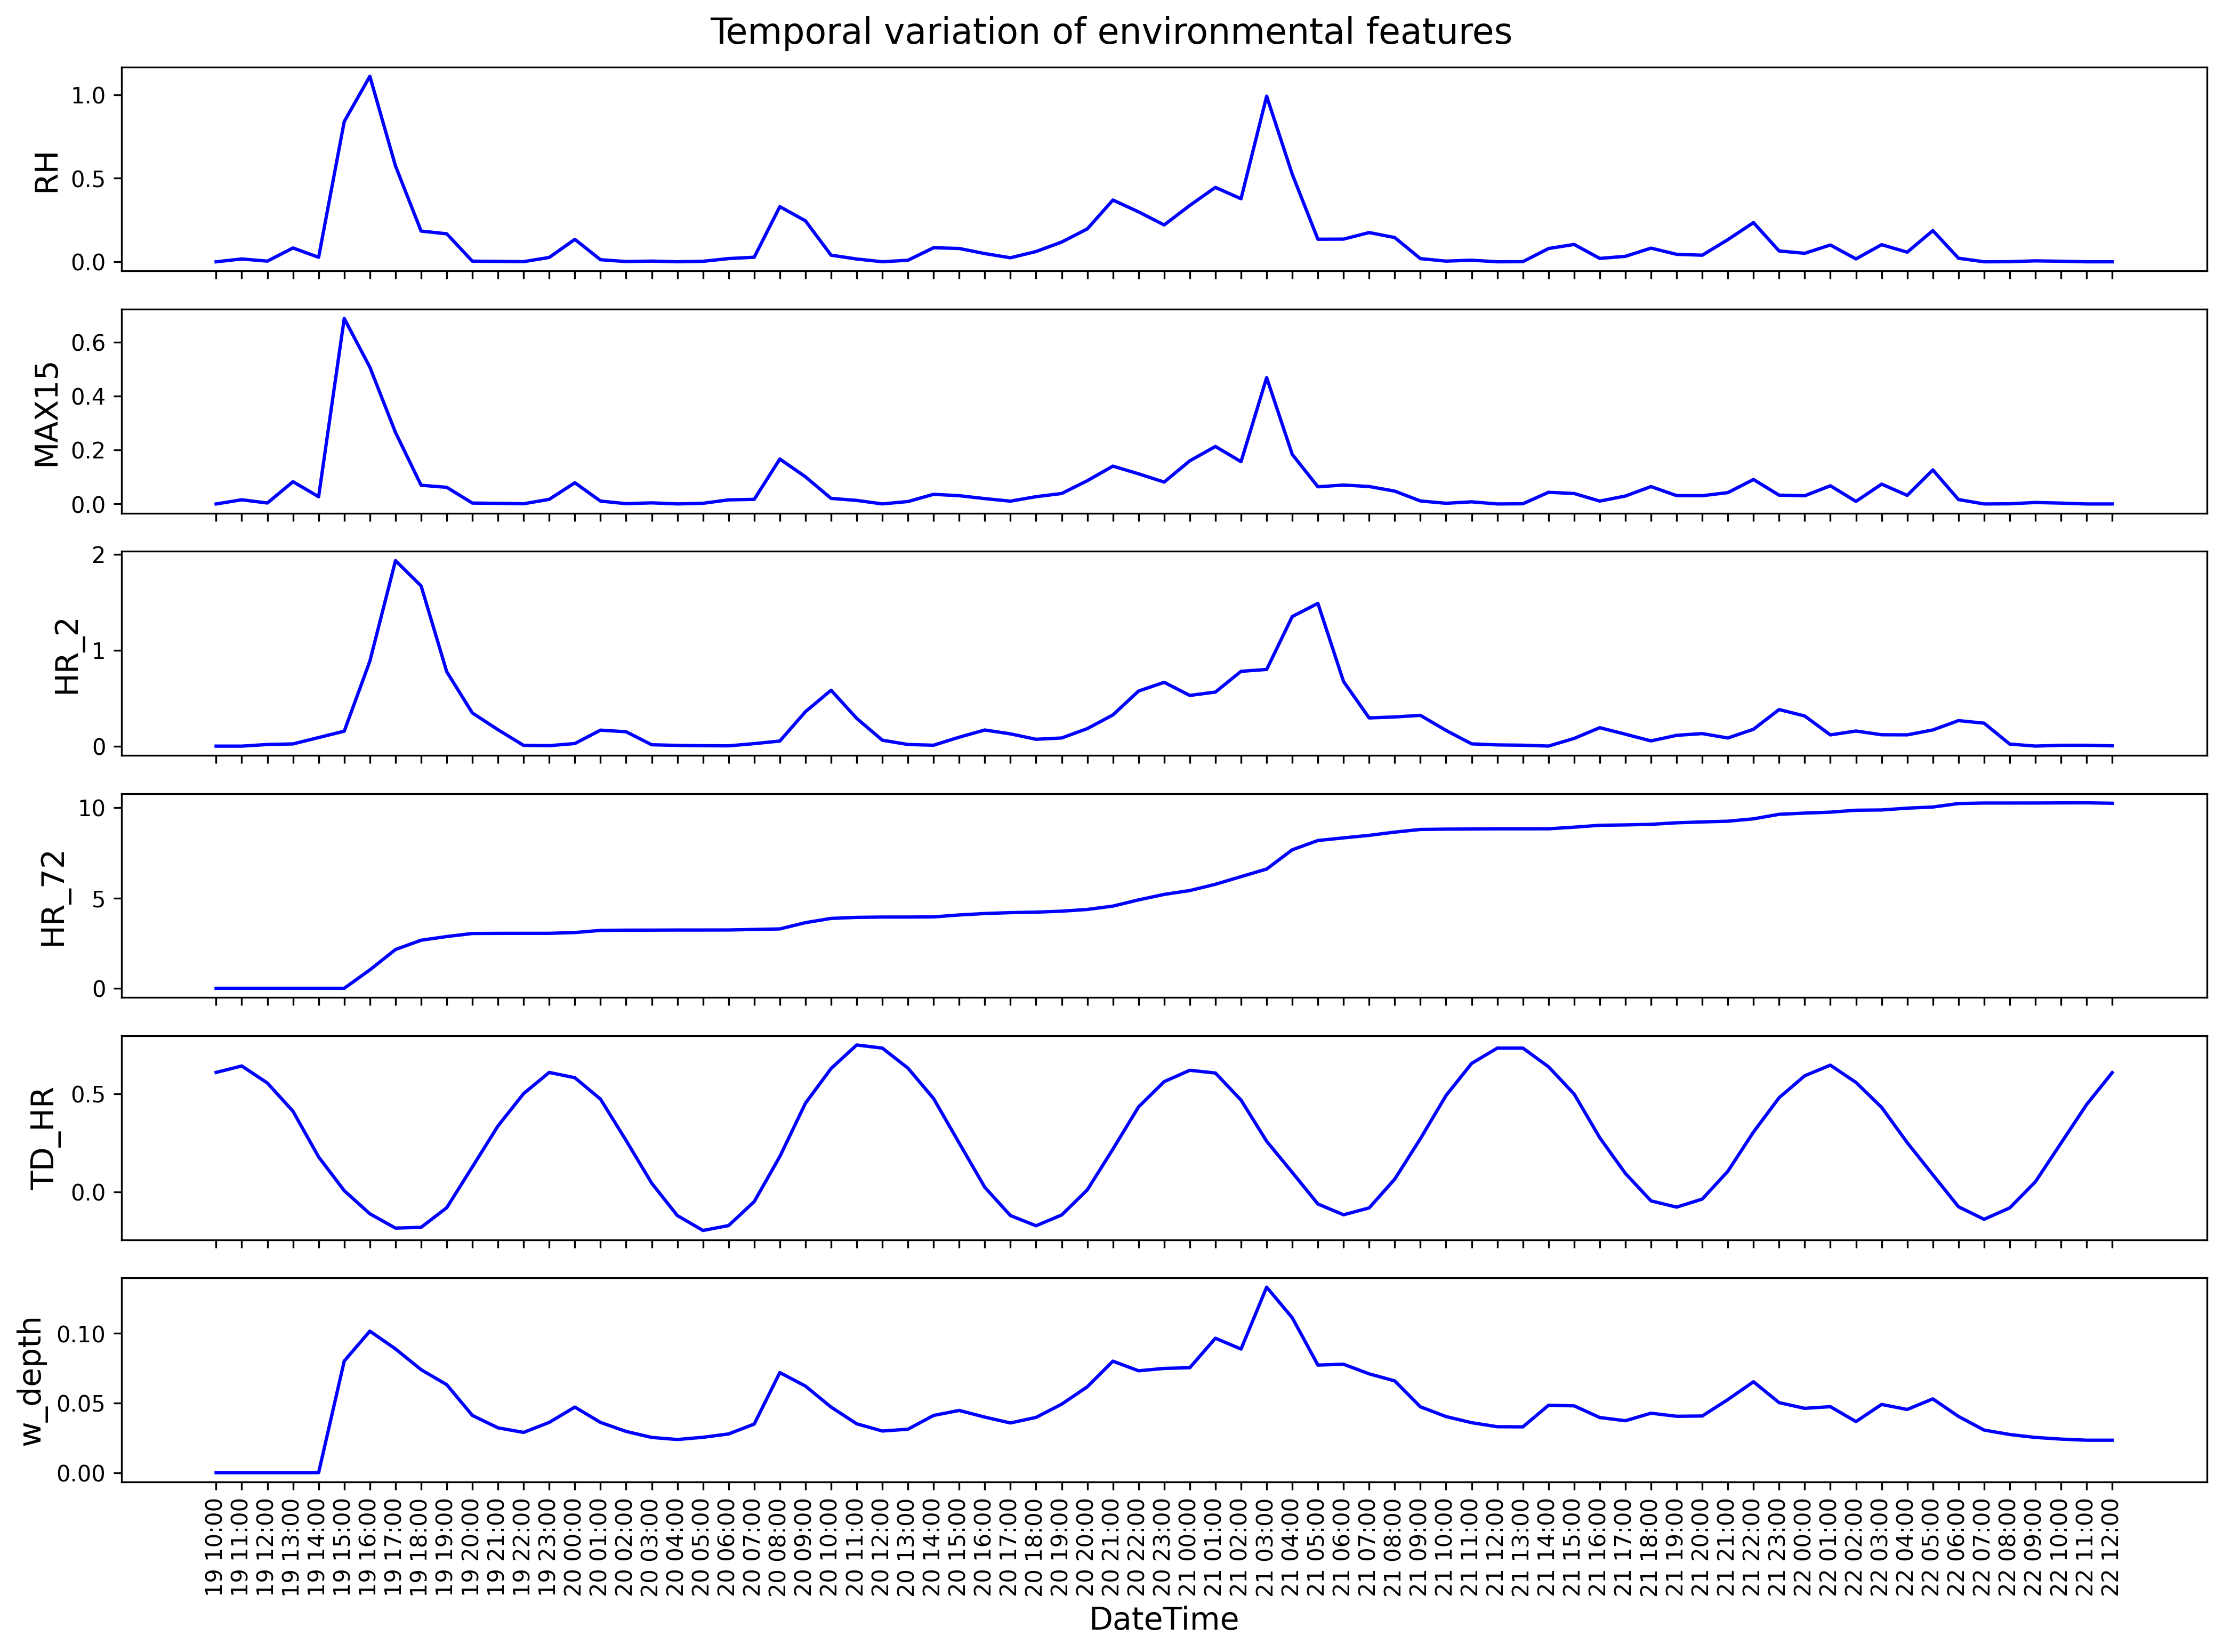

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

path = 'events/2016_09_21.csv'
df = pd.read_csv(path)

print(df.head())


df['DateTime'] = df['DateTime'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[2] + ':00')

df['DateTime1'] = pd.to_datetime(df['DateTime'], format='%d %H:%M')

numeric_cols = [ 'RH', 'MAX15', 'HR_2', 'HR_72', 'TD_HR' , 'w_depth']
df_numeric = df[['DateTime'] + numeric_cols]

df_median = df_numeric.groupby('DateTime').median()

fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(14, 10), sharex=True, dpi=300)

for i, feature in enumerate(numeric_cols):
    axes[i].plot(df_median.index, df_median[feature], label=feature, color='b')
    #axes[i].set_title(f'{feature} over Time')
    axes[i].set_ylabel(feature, fontsize=14)
    #axes[i].legend()

axes[-1].set_xlabel('DateTime', fontsize=14)

fig.suptitle('Temporal variation of environmental features', fontsize=16)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

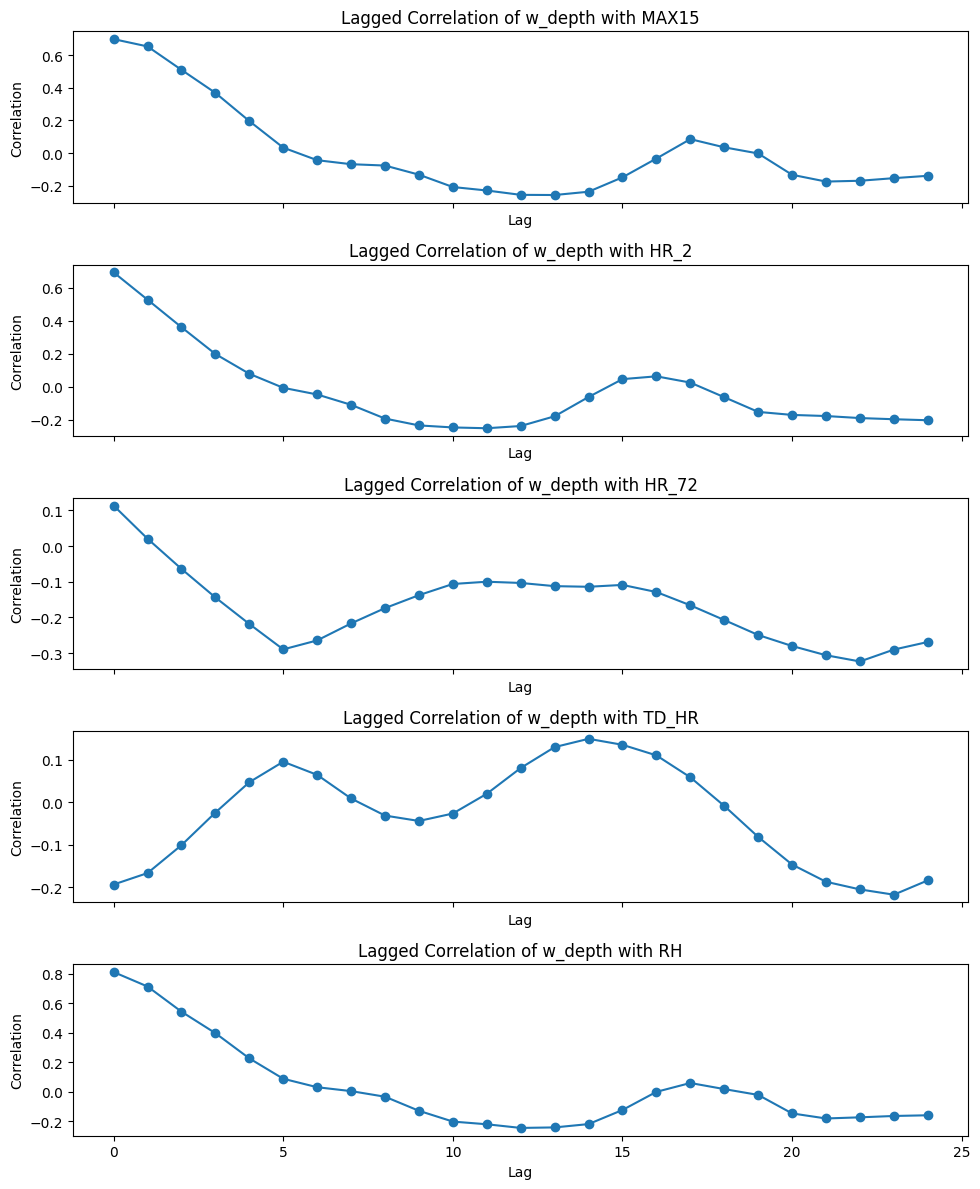

In [ ]:
def calculate_lagged_correlation(series1, series2, max_lag):
    correlations = []
    for lag in range(max_lag + 1):
        # Shift series2 by the current lag and calculate correlation with series1
        corr = series1.corr(series2.shift(lag))
        correlations.append(corr)
    return correlations

max_lag = 24  # Maximum number of lags to consider

fig, axes = plt.subplots(len(numeric_cols) - 1, 1, figsize=(10, 12), sharex=True)

for i, feature in enumerate(numeric_cols):
    if feature != 'w_depth':
        correlations = calculate_lagged_correlation(df_median['w_depth'], df_median[feature], max_lag)
        axes[i - 1].plot(range(max_lag + 1), correlations, marker='o')
        axes[i - 1].set_title(f'Lagged Correlation of w_depth with {feature}')
        axes[i - 1].set_ylabel('Correlation')
        axes[i - 1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

directory = 'test'
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

train_files = csv_files[:2]
test_files = csv_files[2:3]

def load_data(files, directory):
    data = []
    for file in files:
        df = pd.read_csv(os.path.join(directory, file))
        data.append(df)
    return pd.concat(data, ignore_index=True)

train_data = load_data(train_files, directory)
test_data = load_data(test_files, directory)
print(train_data)
print(test_data)

X_train = train_data.drop(columns=['w_depth', 'FID_', 'FULLNAME', 'DateTime'])
y_train = train_data['w_depth']
X_test = test_data.drop(columns=['w_depth', 'FID_', 'FULLNAME', 'DateTime'])
y_test = test_data['w_depth']

print(X_train.head(), X_train.shape )
print(y_train.head(), y_train.shape)


          FID_             FULLNAME   RH     DateTime  MAX15      HR_2  \
0            0  E LITTLE CREEK ROAD  0.0  Jun16_05_01    0.0  0.000000   
1            1  E LITTLE CREEK ROAD  0.0  Jun16_05_01    0.0  0.000000   
2            2  E LITTLE CREEK ROAD  0.0  Jun16_05_01    0.0  0.000000   
3            3  E LITTLE CREEK ROAD  0.0  Jun16_05_01    0.0  0.000000   
4            4  E LITTLE CREEK ROAD  0.0  Jun16_05_01    0.0  0.000000   
...        ...                  ...  ...          ...    ...       ...   
1073525  17497       CHILDRENS LANE  0.0  Jul16_31_21    0.0  0.061088   
1073526  17498       CHILDRENS LANE  0.0  Jul16_31_21    0.0  0.061093   
1073527  17499       FAIRFAX AVENUE  0.0  Jul16_31_21    0.0  0.061233   
1073528  17500       FAIRFAX AVENUE  0.0  Jul16_31_21    0.0  0.061386   
1073529  17501          WOOD STREET  0.0  Jul16_31_21    0.0  0.051361   

            HR_72  w_depth  TD_HR       ELV          DTW       TWI  
0        0.000000   0.0000 -0.126  3.44965

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)





In [ ]:
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
   # Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    #Dropout(0.2),

    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(0.2),

    Dense(32, activation='relu', kernel_regularizer=l2(0.02)),
    Dropout(0.1),

    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.1),

    Dense(1)  # Output layer for regression
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=20, batch_size=10000, validation_split=0.2, verbose=1)

y_train_pred = model.predict(X_train)
train_mse, train_mae = model.evaluate(X_train, y_train, verbose=1)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = model.predict(X_test)
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=1)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training MAE: {train_mae}, Training MSE: {train_mse}, Training R²: {train_r2}")
print(f"Test MAE: {test_mae}, Test MSE: {test_mse}, Test R²: {test_r2}")

Epoch 1/20
86/86 [==============================] - 3s 22ms/step - loss: 0.2066 - mae: 0.0821 - val_loss: 0.0622 - val_mae: 0.0958
Epoch 2/20
86/86 [==============================] - 2s 18ms/step - loss: 0.0449 - mae: 0.0739 - val_loss: 0.0564 - val_mae: 0.0922
Epoch 3/20
86/86 [==============================] - 1s 17ms/step - loss: 0.0415 - mae: 0.0724 - val_loss: 0.0543 - val_mae: 0.0906
Epoch 4/20
86/86 [==============================] - 1s 17ms/step - loss: 0.0399 - mae: 0.0717 - val_loss: 0.0517 - val_mae: 0.0926
Epoch 5/20
86/86 [==============================] - 1s 16ms/step - loss: 0.0387 - mae: 0.0723 - val_loss: 0.0494 - val_mae: 0.0928
Epoch 6/20
86/86 [==============================] - 2s 18ms/step - loss: 0.0375 - mae: 0.0716 - val_loss: 0.0482 - val_mae: 0.0943
Epoch 7/20
86/86 [==============================] - 2s 19ms/step - loss: 0.0367 - mae: 0.0710 - val_loss: 0.0536 - val_mae: 0.0903
Epoch 8/20
86/86 [==============================] - 2s 21ms/step - loss: 0.0366 - m

In [ ]:
from sklearn.decomposition import PCA

variance_threshold = 0.99

pca = PCA(n_components=variance_threshold)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 7


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D


X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=1),
    Dropout(0.3),
    
    Conv1D(32, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=1),
    Dropout(0.3),
    
    
    Conv1D(16, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=1),
    
    Flatten(),
    Dense(8, activation='relu'),
    Dropout(0.2),
   
    Dense(1) 
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train_cnn, y_train, epochs=20, batch_size=10000, validation_split=0.3, verbose=1)

y_train_pred = model.predict(X_train_cnn)
train_r2 = r2_score(y_train, y_train_pred)
y_test_pred = model.predict(X_test_cnn)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")
print(f"Training MAE: {train_mae}, Training MSE: {train_mse}, Training R²: {train_r2}")
print(f"Test MAE: {test_mae}, Test MSE: {test_mse}, Test R²: {test_r2}")

Epoch 1/20
76/76 [==============================] - 18s 228ms/step - loss: 0.0382 - mae: 0.0838 - val_loss: 0.0345 - val_mae: 0.0872
Epoch 2/20
76/76 [==============================] - 15s 201ms/step - loss: 0.0250 - mae: 0.0692 - val_loss: 0.0317 - val_mae: 0.0861
Epoch 3/20
76/76 [==============================] - 14s 182ms/step - loss: 0.0237 - mae: 0.0663 - val_loss: 0.0307 - val_mae: 0.0861
Epoch 4/20
76/76 [==============================] - 17s 219ms/step - loss: 0.0229 - mae: 0.0641 - val_loss: 0.0304 - val_mae: 0.0859
Epoch 5/20
76/76 [==============================] - 17s 226ms/step - loss: 0.0226 - mae: 0.0630 - val_loss: 0.0298 - val_mae: 0.0858
Epoch 6/20
76/76 [==============================] - 17s 225ms/step - loss: 0.0224 - mae: 0.0624 - val_loss: 0.0290 - val_mae: 0.0865
Epoch 7/20
76/76 [==============================] - 17s 227ms/step - loss: 0.0222 - mae: 0.0619 - val_loss: 0.0294 - val_mae: 0.0860
Epoch 8/20
76/76 [==============================] - 18s 233ms/step - 